# Arctic Permafrost Modeling

ATS initial came out of a desire to model Arctic permafrost using the best available understanding of cryosphere processes, including subsurface flow in partially saturated, partially frozen soils.  These simulations form the basis for doing this work, and represent an approach designed for continuous permafrost.

This demo also is useful for seeing how layering works in ATS, as there are heterogeneous properties throughout (peat and mineral soil layers).

The basic spinup of this sequence is as follows:

* spinup0-water_table: Run a steady-state problem to establish a water table
* spinup1-freezeup: Freeze the steady-state water table from below, establishing a saturated ice table.
* spinup2-dynamic: Drive a simulation with an annual, cyclic steady-state meterological data, derived from DayMet but smoothed extensively to generate a climatologically "typical" year.  This establishes a permafrost vs active layer, reasonable saturation state, etc.

After these, many choices are available.  1D column runs could be run using the same input file as spinup2-dynamic and driven with real daily data.  2D or 3D runs on transects, hillslopes, or other geometries can have the result of spinup2-dynamic draped from the surface and lateral flow and spatial variations can be considered.  All of these use the same basic form of input file, with a differing mesh, so we simply demonstrate one, including snow distribution to capture variations in snowpack with topography.

In [1]:
%matplotlib inline
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import parse_xmf
import column_data
import colors
import numpy as np
import matplotlib.cm
from matplotlib import pyplot as plt

/Users/uec/codes/anaconda/2/5.1.0/base/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## spinup0: Richards steady-state
Solve the steady-state Richards equation to establish a water table in hydrostatic equilibrium.


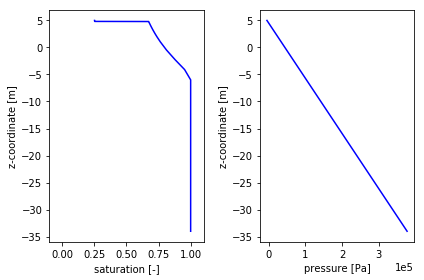

In [6]:
#
# plot the solution
#
def plot(directory, axs, style):
    dati = column_data.column_data(["pressure", "saturation_liquid", "water_content"],
                              keys=1, directory=directory)
    z = dati[0,0,:]
    axs[1].plot(dati[1,0,:],z, style)
    axs[0].plot(dati[2,0,:],z, style)

fig, axs = plt.subplots(1,2)
directory = "spinup0-water_table.demo"
plot(directory, axs, 'b')

axs[0].set_xlim([-.1,1.1])
axs[0].set_xlabel('saturation [-]')
axs[0].set_ylabel('z-coordinate [m]')
axs[1].set_xlabel('pressure [Pa]')
axs[1].set_ylabel('z-coordinate [m]')
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.show()

## spinup1: Freeze steady-state to generate ice column

Transient simulations are initialized in the winter to make spinup simpler.  Therefore we start from a fully frozen domain (instead of the partially frozen domain that would be required for starting any other time of year).  

To establish this fully-frozen domain, we freeze the hydrostatic water column from below until the solution reaches steady-state again.  This "pseudo-transient" approach is easier for solvers than solving the steady-state problem.  This is done in the subsurface only, solving coupled Richards and energy equations.

The bottom boundary temperature is set at -9 F, which is, according to deep borehole data, a reasonable temperature for deep permafrost in Barrow.  As the column freezes, water expands to form ice, pushing the water above it up.  This results in a careful balance -- we want to set the bottom pressure in spinup0 such that, when frozen, the ice table is near the surface, but not above it (which would break the problem here because a no flux condition is put on that top surface).  The calculation of such a pressure is difficult, as it depends upon soil properties, freezing rates, and other dynamic things, so a test-and-check approach is taken.

First, a bottom pressure is set for spinup0, then frozen from below in spinup1.  If the resulting ice table is too high, the pressure in the top cell will blow up, and the process is repeated with a smaller bottom pressure in spinup0.   If the resulting ice table is too low, the entire active layer will happen in an unsaturated zone, and the soil will never saturate.  Typically, for coastal polygonal permafrost, the soil is quite wet, so we work to get the ice table as close to the surface as possible.  More thought might be required for a drier condition, but remember that too wet is rarely an issue (things can drain over a few dynamic years fairly quickly as long as they thaw, but filling up from too dry takes a much longer time).  Bisection on the spinup0 bottom pressure can be used to quickly find a pressure that hits an appropriate ice table level.

NOTE: From here on, transient problems are plotted such that early times have low intensity colors, and late times are high intensity colors.

NOTE: This run takes some time (especially if the code is built in debug mode), ~10 minutes.

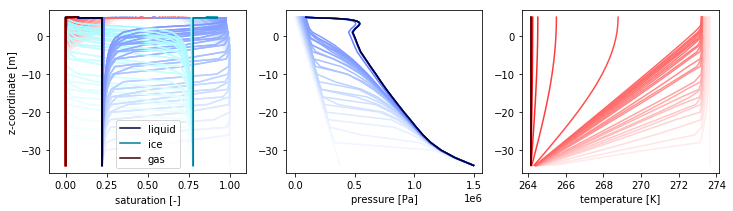

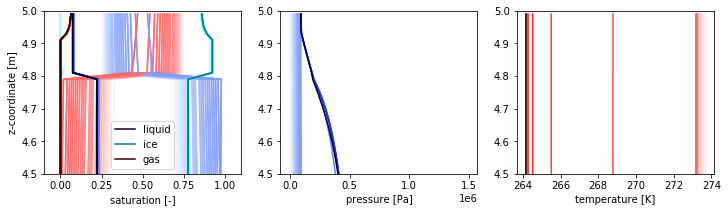

In [9]:
# plot the solution
directory = "spinup1-freezeup.demo"

def plot(directory, axs, style):
    # load the data
    dati = column_data.column_data(["pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"],
                                    directory=directory)
    keys, times, dat = parse_xmf.readATS(directory=directory)

    ice = colors.cm_mapper(-10, times[-1], colors.ice_cmap())
    water = colors.cm_mapper(-10, times[-1], colors.water_cmap())
    gas = colors.cm_mapper(-10, times[-1], colors.gas_cmap())    
    
    # plot saturation of liquid, pressure
    z = dati[0,0,:]
    for i,t in enumerate(times):
        label = False
        if i == len(times)-1:
            axs[0].plot(dati[2,i,:],z, style, color=water(t), label='liquid')
            axs[0].plot(dati[3,i,:],z, style, color=ice(t), label='ice')
            axs[0].plot(dati[4,i,:],z, style, color=gas(t), label='gas')
        else:
            axs[0].plot(dati[2,i,:],z, style, color=water(t))
            axs[0].plot(dati[3,i,:],z, style, color=ice(t))
            axs[0].plot(dati[4,i,:],z, style, color=gas(t))
        axs[2].plot(dati[5,i,:],z, style, color=gas(t))
        axs[1].plot(dati[1,i,:],z, style, color=water(t))
        axs[0].plot(dati[2,i,:],z, style, color=water(t))
        axs[0].plot(dati[3,i,:],z, style, color=ice(t))
        axs[0].plot(dati[4,i,:],z, style, color=gas(t))

def decorate(axs):
    axs[0].set_xlabel('saturation [-]')
    axs[0].set_ylabel('z-coordinate [m]')
    axs[1].set_xlabel('pressure [Pa]')
    axs[2].set_xlabel('temperature [K]')
    axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axs[0].set_xlim([-.1,1.1])
    axs[0].legend()


# full column
fig, axs = column_data.getFigs(False, True)
plot(directory, axs, '-')
decorate(axs)

# and a zoomed version
fig, axs = column_data.getFigs(False, True)
plot(directory, axs, '-')
decorate(axs)
axs[0].set_ylim([4.5,5])
axs[1].set_ylim([4.5,5])
axs[2].set_ylim([4.5,5])


plt.show()
            

## spinup2: Dynamic fully coupled run with annual cyclic steady state forcing

Finally, spinup2 demonstrates the typical transient column run.  This includes all thermal hydrology processes:

* subsurface flow (modified Richards)
* subsurface energy
* surface flow
* surface energy
* surface energy balance

This model is forced with meteorological data.  Here we will use DayMet, which provides daily historical QA'd datasets for meteorological data on a 1km US grid, and covers Alaska.  These datasets were created using DayMet for Barrow:

```python $ATS_SRC_DIR/tools/utils/daymet_to_ats.py 71.2718 -156.6202```

and then smoothed to generate spinup data via:

```python $ATS_SRC_DIR/tools/utils/smooth_met.py -n 10 daymet_raw_71p2718_-156p6202.h5```

This is called a spinup run because it sets a typical cyclic steady state, and puts the permafrost a reasonable state to then do dynamic, "real data" runs with met data from real years instead of averaged, typical years.  These dynamic runs use the same transient processes, just different forcing data.


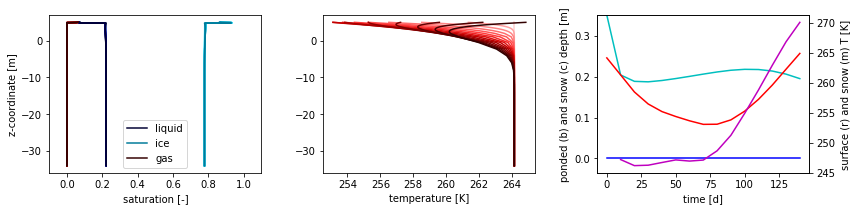

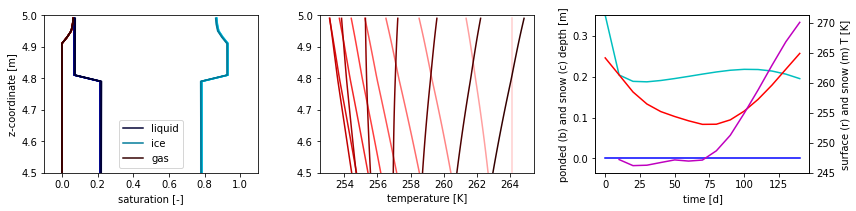

In [13]:
# plot the solution
directory = "spinup2-dynamic.demo"

def plot(directory, axs, style):
    # load the data
    dati = column_data.column_data(["pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"],
                                    directory=directory)
    keys, times, dat = parse_xmf.readATS(directory=directory)
    skeys, stimes, sdat = parse_xmf.readATS(directory=directory, base="visdump_surface_data.h5")
    snkeys, sntimes, sndat = parse_xmf.readATS(directory=directory, base="visdump_snow_data.h5")
    
    # convert times to days
    times = [time*365.25 for time in times]

    ice = colors.cm_mapper(-10, times[-1], colors.ice_cmap())
    water = colors.cm_mapper(-10, times[-1], colors.water_cmap())
    gas = colors.cm_mapper(-10, times[-1], colors.gas_cmap())    
    
    # plot saturation of liquid, pressure
    z = dati[0,0,:]
    for i,t in enumerate(times):
        axs[1].plot(dati[5,i,:],z, style, color=gas(t))
        if i == len(times)-1:
            axs[0].plot(dati[2,i,:],z, style, color=water(t), label='liquid')
            axs[0].plot(dati[3,i,:],z, style, color=ice(t), label='ice')
            axs[0].plot(dati[4,i,:],z, style, color=gas(t), label='gas')
        else:
            axs[0].plot(dati[2,i,:],z, style, color=water(t))
            axs[0].plot(dati[3,i,:],z, style, color=ice(t))
            axs[0].plot(dati[4,i,:],z, style, color=gas(t))
            
    # inset -- plot surface water
    pd = parse_xmf.getSurfaceData(keys, sdat, 'surface-ponded_depth.cell.0')
    axs[2].plot(times, pd, 'b')
    if pd.max() > 0:
        axs[2].set_ylim([-.1*pd.max(), pd.max()])

    # plot snow
    snow = parse_xmf.getSurfaceData(keys, sndat, 'snow-depth.cell.0')
    snow = snow + pd
    axs[2].plot(times, snow, 'c')
    if snow.max() > 0:
        axs[2].set_ylim([-.1*snow.max(), snow.max()])
        
    # plot surface temp
    surf_T = parse_xmf.getSurfaceData(keys, sdat, "surface-temperature.cell.0")
    axs[3].plot(times, surf_T, 'r')
    
    # plot snow temp
    snow_T = parse_xmf.getSurfaceData(keys, sndat, 'snow-temperature.cell.0')
    snow_T[0] = np.nan # this is initially zero which screws up the plot
    axs[3].plot(times, snow_T, 'm')

def decorate(axs):
    axs[0].set_xlim([-.1,1.1])
    axs[0].set_xlabel('saturation [-]')
    axs[0].set_ylabel('z-coordinate [m]')
    axs[0].legend()
    axs[1].set_xlabel('temperature [K]')
    axs[2].set_xlabel('time [d]')
    axs[2].set_ylabel('ponded (b) and snow (c) depth [m]')
    axs[3].set_ylabel('surface (r) and snow (m) T [K]')

fig, axs = plt.subplots(1,3, figsize=(12,3))
twinax = axs[2].twinx()
axs = list(axs)

axs.append(twinax)

plot(directory, axs, '-')
decorate(axs)
plt.tight_layout()
              
# zoom
fig, axs = plt.subplots(1,3, figsize=(12,3))
twinax = axs[2].twinx()
axs = list(axs)
axs.append(twinax)

plot(directory, axs, '-')
decorate(axs)
axs[0].set_ylim((4.5,5))
axs[1].set_ylim((4.5,5))
plt.tight_layout()
plt.show()